1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
0 [D loss: 1.2228319644927979 | D accuracy: 32.03125] [G loss: 1.1017951965332031]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1 [D loss: 1.0448378324508667 | D accuracy: 44.40104365348816] [G loss: 1.1507842540740967]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2 [D loss: 1.0386667251586914 | D accuracy: 47.968751192092896] [G loss: 1.127538800239563]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3 [D loss: 1.0415934324264526 | D accuracy: 48.40959906578064] [G loss: 1.1449344158172607]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4 [D loss: 1.0395739078521729 | D accuracy: 48.45485985279083] [G loss: 1.1479721069335938]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5 [D loss: 1.0383356809616089 | D accuracy: 47.502368688583374] [G loss: 1.1388834714889526]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
6 [D loss: 1.0230902433395386 | D accuracy: 47.40728139877319] [G loss: 1.1181589365005493]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
7 [D loss: 1.0179353

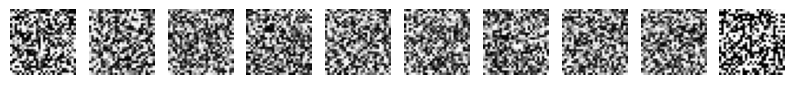

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset (28x28 grayscale images of digits)
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize images to the range [-1, 1]
x_train = x_train.astype("float32") / 127.5 - 1.0

# Reshape images to be (batch_size, 28, 28, 1) for the model
x_train = np.expand_dims(x_train, axis=-1)

# Build the generator model
def build_generator():
    model = Sequential()

    # Dense layer with 128 units and input noise vector (100 dimensions)
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    # Another dense layer to increase spatial resolution
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    # Another dense layer to increase spatial resolution
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    # Output layer - Reshape into 28x28x1 image (grayscale)
    model.add(layers.Dense(np.prod((28, 28, 1)), activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

# Build the discriminator model
def build_discriminator():
    model = Sequential()

    # Input layer (28x28x1 image)
    model.add(layers.Flatten(input_shape=(28, 28, 1)))

    # Dense layers with dropout to reduce overfitting
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))

    # Output layer - Predicts if the image is real or fake
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Build the GAN model combining the generator and discriminator
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Instantiate the models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Compile the Discriminator model
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Compile the GAN model
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')

# Define the loss function and optimizer
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Train the GAN
def train_gan(epochs, batch_size=64, save_interval=100):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train Discriminator: real and fake images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Labels for real and fake images
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        # Train the discriminator (real images, fake images)
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator (try to fool the discriminator)
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print the progress
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")

        # Save generated images at intervals
        if epoch % save_interval == 0:
            save_generated_images(epoch)

# Save the generated images during training
def save_generated_images(epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)

    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()

# Start training the GAN (epochs can be adjusted)
train_gan(epochs=1000, batch_size=64, save_interval=1000)

# Generate new images after training
def generate_new_images():
    noise = np.random.normal(0, 1, (10, 100))  # Generate 10 random noise vectors
    generated_images = generator.predict(noise)

    plt.figure(figsize=(10, 1))

    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')

    plt.show()

# Generate new images after the training process
generate_new_images()
